In [1]:
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
execfile('../../matplotlibrc.py')

In [3]:
imax = 513
jmax = 257
TE_start = 65 - 1  # Trailing Edge Lower Point
TE_end = 449 - 1    # Trailing Edge Upper Point
LE = 257 - 1       # Leading Edge Point
gamma = 1.4
mach = 0.1
p0 = 1.0  # Freestream static pressure
alpha = np.deg2rad(8.0)  # Angle of Attack
Re = 3e6  # Reynolds number

SCF = 1.0/(0.5*gamma*p0*mach**2)

In [4]:
variables = ['X', 'Y', 'RHO', 'RHO-U', 'RHO-V', 'RHO-E', 'MU', 'REV', 'D2WALL']
variables = ['"%s"'%v for v in variables]
with open('tecdata.dat', 'w') as f:
    f.write(' TITLE = "PROJECT 5"\n')
    f.write(' FILETYPE = FULL\n')
    f.write(' VARIABLES = %s\n' % ' '.join(variables))
    f.write(' ZONE\n')
    f.write(' I = %i, J = %i, F=POINT\n' % (imax, jmax))
    f.write(open('NACA0012_flowfieldv2.dat').read())

In [5]:
dat = np.genfromtxt('NACA0012_flowfieldv2.dat', unpack=True)

In [6]:
def unpack(cols):
    r = []
    for col in cols:
        r.append(col.reshape((jmax, imax)).T)
    return r

In [7]:
x, y = unpack(dat[0:2,:])
w = np.empty((4, imax, jmax))
w[:] = unpack(dat[2:6])
rlv, rev, d2wall = unpack(dat[6:])
dwall = np.sqrt(d2wall)
rho = w[0]
u = w[1]/rho
v = w[2]/rho
UV = np.array([u, v])
pressure = (gamma - 1)*( w[3] - 0.5*(w[1]**2 + w[2]**2)/w[0] )
U = np.sqrt(u**2 + v**2)

In [8]:
airfoil = np.s_[TE_start:TE_end+1]
wall = np.index_exp[airfoil,0]
upper = np.s_[LE - TE_start:]
lower = np.s_[:LE - TE_start]

## Compute surface values

In [9]:
num_airfoil_nodes = TE_end - TE_start + 1
normals = np.empty((num_airfoil_nodes - 1, 2))
UVc = np.empty_like(normals)
areas = np.empty(num_airfoil_nodes - 1)
thetas = np.empty_like(areas)
xc = np.empty_like(areas)
yc = np.empty_like(areas)
cp = np.empty_like(areas)
x_wall = x[wall]
y_wall = y[wall]
p_wall = pressure[wall]
UV_wall = UV[:, airfoil, 1]
assert num_airfoil_nodes == len(x_wall)
for i in range(num_airfoil_nodes - 1):
    xc[i] = 0.5*(x_wall[i+1] + x_wall[i])
    yc[i] = 0.5*(y_wall[i+1] + y_wall[i])
    UVc[i] = 0.5*(UV_wall[:,i+1] + UV_wall[:,i])
    pc = 0.5*(p_wall[i+1] + p_wall[i])
    cp[i] = (pc/p0 - 1)*SCF
    dx = x_wall[i+1] - x_wall[i]
    dy = y_wall[i+1] - y_wall[i]
    l = np.sqrt(dy**2 + dx**2)
    thetas[i] = np.arctan2(dy,dx)
    normals[i] = np.array([-dy, dx])/l
    areas[i] = l  # Assume span = 1
    
# Adjust for upstream-poiting angles on the lower surface
stag_idx = np.logical_and(xc[lower] < 0.5, UVc[lower,0] < 0).argmax()
thetas[lower][:stag_idx] = np.pi + thetas[lower][:stag_idx]

In [10]:
# Compute nodal stress tensor on wall
# gradUV = np.empty((num_airfoil_nodes, 2, 2))
wall2global = np.arange(airfoil.start, airfoil.stop + 1, 1)
gradUV = np.empty((2, 2))
tau_na = np.empty((num_airfoil_nodes, 2))  # tau_n and tau_a
for n in range(1, num_airfoil_nodes - 1):
    gn = wall2global[n]
    dxdi = 0.5*(x[gn+1,0] - x[gn-1,0])
    dxdj = x[gn,1] - x[gn,0]
    dydi = 0.5*(y[gn+1,0] - y[gn-1,0])
    dydj = y[gn,1] - y[gn,0]
    J = 1/(dxdi*dydj - dxdj*dydi)
    didx = J*dydj
    djdx = -J*dydi
    didy = -J*dxdj
    djdy = J*dxdi
    for k in range(2):
        dUVdi = 0.5*(UV[k,gn+1,0] - UV[k,gn-1,0])
        dUVdj = UV[k,gn,1] - UV[k,gn,0]
        gradUV[k,0] = dUVdi*didx + dUVdj*djdx
        gradUV[k,1] = dUVdi*didy + dUVdj*djdy
    
    
    mu = rlv[gn,0]
    term = (-2.0/3.0)*mu*(gradUV[0,0] + gradUV[1,1])
    tauxx = 2*mu*gradUV[0,0] + term
    tauyy = 2*mu*gradUV[1,1] + term
    tauxy = mu*(gradUV[0,1] + gradUV[1,0])
    nx, ny = 0.5*(normals[n-1] + normals[n])
    
    tau_na[n,0] = nx*tauxy + ny*tauyy
    tau_na[n,1] = nx*tauxx + ny*tauxy
    
tau_nc = np.empty(num_airfoil_nodes - 1)  # Tau_n at cell center
tau_ac = np.empty_like(tau_nc)            # Tau_a at cell center
for n in range(1, num_airfoil_nodes - 1):
    tau_nc[n], tau_ac[n] = 0.5*(tau_na[n+1,:] + tau_na[n,:])
tau_nc[0], tau_ac[0] = tau_na[1]
tau_nc[-1], tau_ac[-1] = tau_na[-2]

In [11]:
tau_wc = np.empty_like(tau_nc)
cf = np.empty_like(tau_nc)
for e int range(len(tau_nc)):
#     tau_wc[e] = np.array([tau_ac[e], tau_nc[e]]).dot(tangents[e])
    t = thetas[e]
    tau_wc[e] = tau_ac[e]*np.cos(t) + tau_nc[e]*np.sin(t)
    cf[e] = tau_wc[e]*SCF

In [12]:
def savefig(fig, name):
    filepath = os.path.join('tex', 'figs', name)
    fig.savefig(filepath)

# Question 1

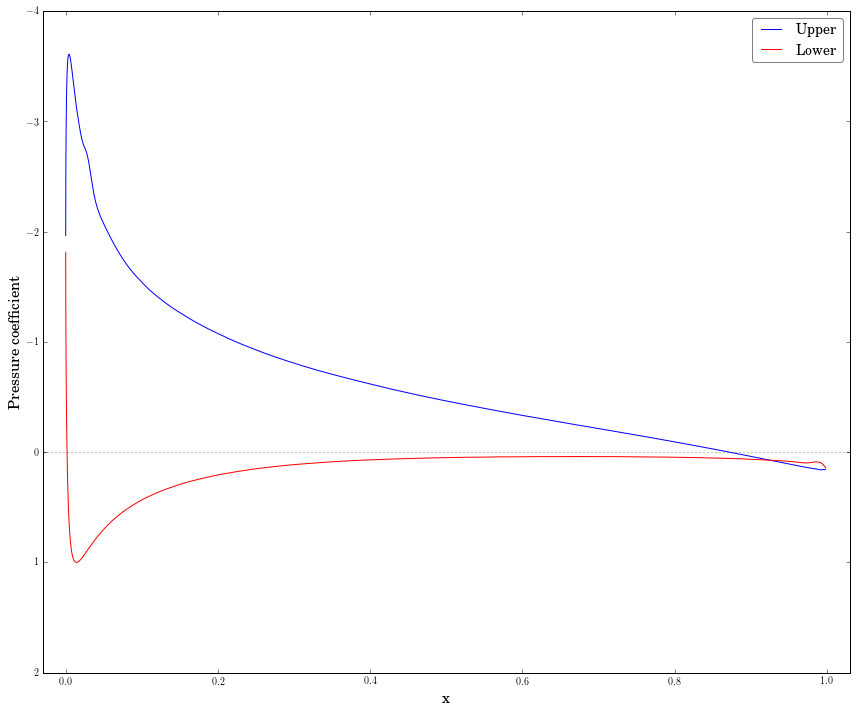

In [13]:
def q1():
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.plot(xc[upper], cp[upper], 'b', label='Upper')
    ax.plot(xc[lower], cp[lower], 'r', label='Lower')
    ax.invert_yaxis()
    ax.legend()
    ax.set_ylabel('Pressure coefficient')
    ax.set_xlabel('x')
    ax.set_xlim(-0.03, 1.03)
    ax.set_yticks([0.0], minor=True)
    ax.grid(True, which='minor', axis='y')
    fig.tight_layout()
    savefig(fig, 'cp.pdf')
    plt.show()
    
q1()

## Question 2

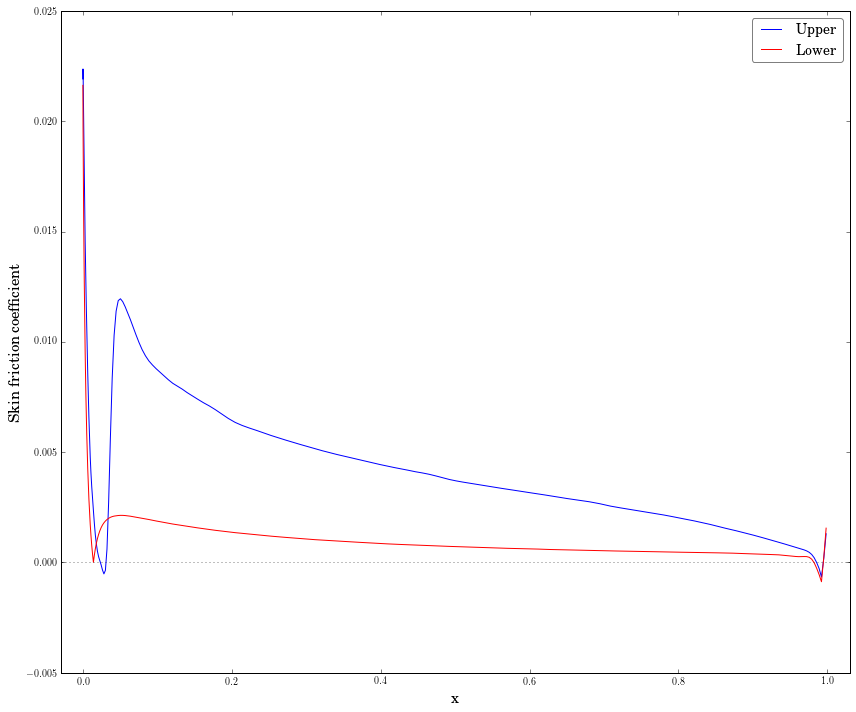

In [14]:
def q2():
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.plot(xc[upper], cf[upper], 'b', label='Upper')
    ax.plot(xc[lower], cf[lower], 'r', label='Lower')
    ax.legend()
    ax.set_ylabel('Skin friction coefficient')
    ax.set_xlabel('x')
    ax.set_xlim(-0.03, 1.03)
    ax.set_yticks([0.0], minor=True)
    ax.grid(True, which='minor', axis='y')
    fig.tight_layout()
    savefig(fig, 'cf.pdf')
    plt.show()

q2()

## Question 3

In [15]:
def q3():
    cnp = np.sum(-cp*normals[:,1]*areas)
    cap = np.sum(-cp*normals[:,0]*areas)
    cdp = cnp*sin(alpha) + cap*cos(alpha)
    clp = cnp*cos(alpha) - cap*sin(alpha)

    cnv = np.sum(tau_nc*areas)*SCF
    cav = np.sum(tau_ac*areas)*SCF
    cdv = cnv*sin(alpha) + cav*cos(alpha)
    clv = cnv*cos(alpha) - cav*sin(alpha)

    cd = cdp + cdv
    cl = clp + clv
    
    table_fmt = r'''
    \begin{tabular}{@{} l ccc c ccc}
    \toprule
     & \multicolumn{3}{c}{Lift} & \phantom{a} & \multicolumn{3}{c}{Drag}\\
    \cmidrule{2-4}\cmidrule{6-8}
    Source & Pressure & Viscous & Total && Pressure & Viscous & Total\\
    \midrule
    MECH 539 & %(lift)s && %(drag)s\\
    Ladson & - & - & 0.8386 && - & - & 0.0079\\
    \bottomrule
    \end{tabular}
    '''
    fmt = '%.4f'
    lift = ' & '.join([fmt % v for v in [clp, clv, cl]])
    drag = ' & '.join([fmt % v for v in [cdp, cdv, cd]])
    table = table_fmt % dict(lift=lift, drag=drag)
    print(table)
    open('tex/tableq3.tex', 'w').write(table)
    
q3()


    \begin{tabular}{@{} l ccc c ccc}
    \toprule
     & \multicolumn{3}{c}{Lift} & \phantom{a} & \multicolumn{3}{c}{Drag}\\
    \cmidrule{2-4}\cmidrule{6-8}
    Source & Pressure & Viscous & Total && Pressure & Viscous & Total\\
    \midrule
    MECH 539 & 0.8091 & -0.0001 & 0.8089 && 0.0048 & 0.0049 & 0.0098\\
    Ladson & - & - & 0.8386 && - & - & 0.0079\\
    \bottomrule
    \end{tabular}
    


## Question 4

TO DO:
1. Stagnation on lower (in TeX). Use stagnation picture. 
1. Separation on upper. Show laminar/turbulent on either side
1. Separation on upper/lower at TE

In [105]:
def find_zero_cross(x, z, y=None):
    IDX = np.where(np.diff(np.sign(z)))[0]
    x_cross = []
    y_cross = []
    for i in IDX:
        q = (0.0 - z[i])/(z[i+1] - z[i])
        x_cross.append(x[i] + q*(x[i+1] - x[i]))
        if y is not None:
            y_cross.append(y[i] + q*(y[i+1] - y[i]))
            
    if y is None:
        return np.array(x_cross), IDX
    else:
        return np.array(x_cross), np.array(y_cross), IDX
    

def identify_sections(ax, zero_cross, xlim1, xlim2):
    ax.set_xticks(zero_cross)
    ax.set_xticklabels(['%.3f' % v for v in zero_cross])
    laminar = 0.5*(zero_cross[-2] + xlim1)
    recirculation = 0.5*(zero_cross[-2] + zero_cross[-1])
    turbulent = 0.5*(zero_cross[-1] + xlim2)
    ax.set_xticks([laminar, recirculation, turbulent], minor=True)
    ax.set_xticklabels(['Laminar', 'Recirculation', 'Turbulent'], minor=True, fontsize='large')
    ax.xaxis.set_tick_params(which='minor', length=0, pad=15)

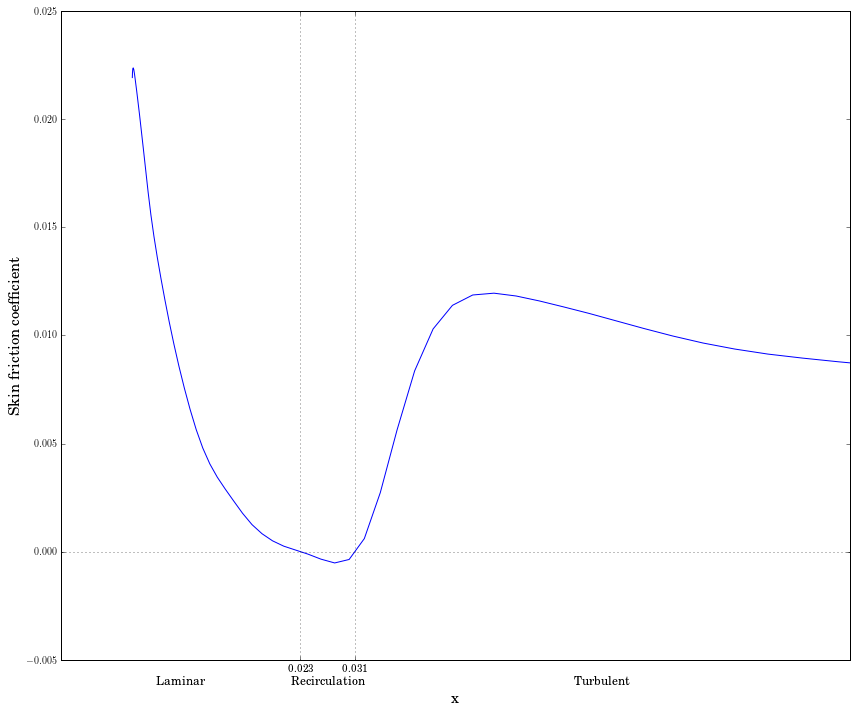

In [106]:
def cf_upper():    
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.plot(xc[upper], cf[upper], 'b', label='Upper')
    ax.set_ylabel('Skin friction coefficient')
    ax.set_xlabel('x')
    zero_cross, _ = find_zero_cross(xc[upper], cf[upper])
    xlim1, xlim2 = -0.01, 0.1
    identify_sections(ax, zero_cross[:2], xlim1, xlim2)
    ax.set_xlim(xlim1, xlim2)
    ax.set_yticks([0.0], minor=True)
    ax.grid(True, which='minor', axis='y')
    ax.grid(True, which='major', axis='x')
    fig.tight_layout()
    savefig(fig, 'cf_upper_le.pdf')
    plt.show()
    
cf_upper()

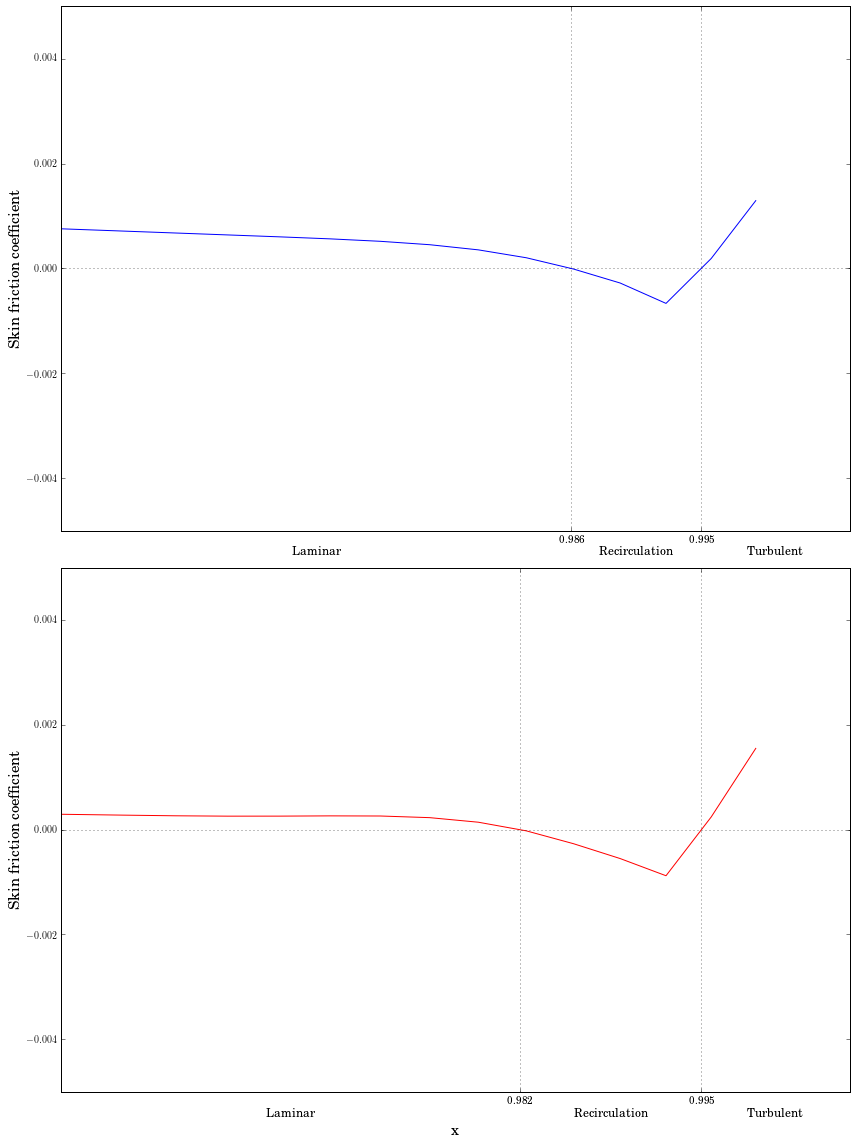

In [114]:
def cf_te():
    fig, (ax_up, ax_bot) = plt.subplots(nrows=2, figsize=(12, 16))
    axes = [ax_up, ax_bot]

    ax_up.plot(xc[upper], cf[upper], 'b')
    ax_bot.plot(xc[lower], cf[lower], 'r')

    ax_bot.set_xlabel('x')

    xlim1, xlim2 = 0.95, 1.005
    ylim1, ylim2 = -0.005, 0.005

    for i, mask in enumerate([upper, lower]):
        sort = np.argsort(xc[mask])
        xc_s = xc[mask][sort]
        zero_cross, _ = find_zero_cross(xc_s, cf[mask][sort])
        ax = axes[i]
        identify_sections(ax, zero_cross, xlim1, xlim2)
        ax.set_xlim(xlim1, xlim2)
        ax.set_yticks([0.0], minor=True)
        ax.grid(True, which='minor', axis='y')
        ax.grid(True, which='major', axis='x')
        ax.set_ylabel('Skin friction coefficient')
        ax.set_ylim(ylim1, ylim2)

    fig.tight_layout()
    savefig(fig, 'cf_te.pdf')
    plt.show()
    
cf_te()

In [117]:
##### KEEEEPP MEEEEEE  ######

n_lam = LE - TE_start + 25
mid = np.argsort(np.abs(xc - 0.5))[:2]

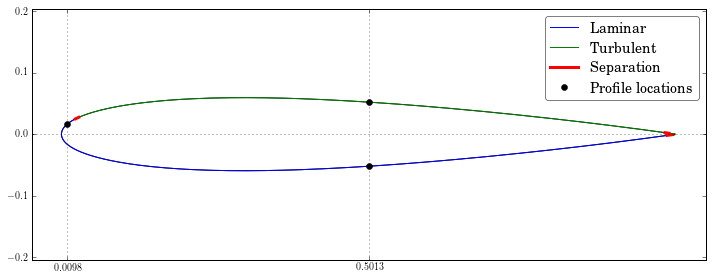

In [118]:
def airfoil_sections():
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(xc, yc, 'k-')
    x_cross, y_cross, cross_id = find_zero_cross(xc, cf, yc)
    mask = np.s_[cross_id[1]:cross_id[2]]
    ax.plot(xc[mask], yc[mask], 'b', label='Laminar')
    mask = np.s_[:cross_id[0]]
    ax.plot(xc[mask], yc[mask], 'g', label='Turbulent')
    mask = np.s_[cross_id[0]:cross_id[1]]
    ax.plot(xc[mask], yc[mask], 'r', label='Separation', lw=3)
    mask = np.s_[cross_id[2]:cross_id[3]]
    ax.plot(xc[mask], yc[mask], 'r', lw=3)
    mask = np.s_[cross_id[3]:cross_id[4]]
    ax.plot(xc[mask], yc[mask], 'g')
    mask = np.s_[cross_id[4]:cross_id[5]]
    ax.plot(xc[mask], yc[mask], 'r', lw=3)
    mask = np.s_[cross_id[5]:]
    ax.plot(xc[mask], yc[mask], 'g')

    ax.plot(xc[n_lam], yc[n_lam], 'ko')
    ax.plot(xc[mid], yc[mid], 'ko', label='Profile locations')
    ticks = [xc[n_lam], xc[mid][0]]
    ax.set_xticks(ticks)

    ax.legend(numpoints=1)
    ax.set_yticks([0.0], minor=True)
    ax.grid(True, which='major', axis='x')
    ax.grid(True, which='minor', axis='y')
    ax.set_aspect('equal', 'datalim')
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.2, 0.2)
    fig.tight_layout()
    savefig(fig, 'airfoil_sections.pdf')
    plt.show()

airfoil_sections()

In [116]:
def uyplus(n):    
    def reject(a, b):
        """Reject vector a onto b"""
        proj = b*a.dot(b)
        return a - proj
    
    gn = wall2global[n]
    tw = tau_wc[n]
    rhow = w[0,gn,0]
    muw = rlv[gn,0]
    ustar = np.sqrt(tw/rhow)
    nu = muw/rhow
    # Wall distance
    y_l = 0.5*(y[gn, :100] + y[gn + 1, :100])
    x_l = 0.5*(x[gn, :100] + x[gn + 1, :100])
    p = np.array([x_l, y_l]).T
    p0 = p[0]
    d = p - p0
    dwall = np.sqrt(d[:,0]**2 + d[:,1]**2)
    yplus = dwall*ustar/nu
    # Tangent velocity
    u_l = 0.5*(u[gn, :100] + u[gn + 1, :100])
    v_l = 0.5*(v[gn, :100] + v[gn + 1, :100])
    ut = np.empty_like(u_l)
    normal = normals[n]
    for i, uv_l in enumerate(zip(u_l, v_l)):
        ut[i] = np.linalg.norm(reject(np.array(uv_l), normal))

    uplus = ut/ustar
    uplus_log = 1/0.41*np.log(yplus[1:]) + 5.0
    return yplus, uplus, uplus_log

In [126]:
def uplus_plot(ax, n):
    yplus, uplus, uplus_log = uyplus(n)
    ax.semilogx(yplus, uplus)
    ax.semilogx(yplus, yplus, 'k--')
    ax.semilogx(yplus[1:], uplus_log, 'k--')
    ax.set_xlabel('y+')
    ax.set_ylabel('u+')
    ax.set_ylim(0, uplus.max()*1.1)

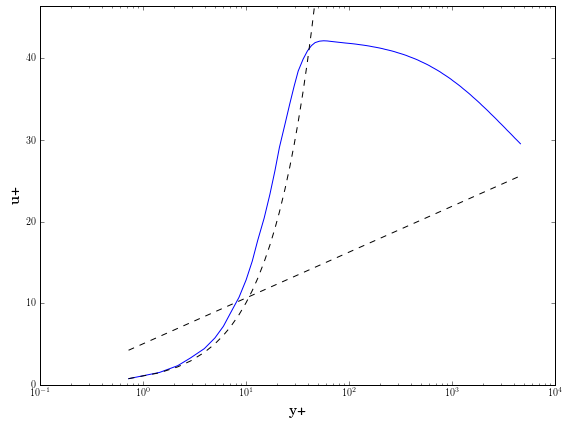

In [127]:
# def uplus_upper_le():
fig, ax = plt.subplots(figsize=(8, 6))

uplus_plot(ax, n_lam)
fig.tight_layout()
plt.show()

In [81]:
# fig, ax = plt.subplots(figsize=(12, 12))
# n = n_lam - 5
# gn = wall2global[n]
# ax.plot(xc, yc, 'k-')
# p0 = np.array([xc[n], yc[n]])
# ax.scatter(*p0, color='r')
# ax.plot(x[gn, :100], y[gn, :100])
# ax.plot(x[gn+1, :100], y[gn+1, :100])
# p1 = p0 + normals[n]*0.01
# ax.plot([p0[0], p1[0]], [p0[1], p1[1]], 'k-')
# xlims = np.array([0.95, 1.05])*xc[n]
# ax.set_xlim(*xlims)
# ax.set_aspect('equal', 'datalim')